L'objet de cette étude est de mettre en place un modèle de prédiction du montant de la transaction immobilière d'un bien à partir de caractéristiques observables du bien (surface, nombre de pièces, ...) et de variables sur l'environnement du bien (niveau de vie alentour, nombre de commerces alentours, densité de la population, ...). Cette [page](http://doc-datafoncier.cerema.fr/dv3f/tuto/g1_denombrer#notion-de-parcelles-mutees-parcelles-concernees) présente la définition des concepts **mutation, parcelle, local**.

In [1]:
# Chargement des différents modules de travail
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh import __version__ as bk_version

# 1. Chargement du jeu de données

Le jeu de données utilisée dans le cadre de ce travail porte sur la Demande de Valeurs Foncières en Île-de-France au cours du 3e trimestre de l'année 2020. Les données sont disponibles en open source au format SQL via ce [lien](https://cerema.app.box.com/v/dvfplus-opendata/folder/125288298156). Nous les avons importés sur PostgreSQL, traités, puis convertis au format csv. Le jeu de données final, d'une taille de 12Go, est accessible à partir de ce [lien](https://drive.google.com/file/d/1mEpp7Mi6VuezR4OI-cVEHPbfu4Gn_A2v/view?usp=sharing). Dans le cadre de ce projet, nous chargerons le jeu de données à partir du fichier csv sauvegardé en local et non à partir du lien précédent afin de limiter le temps de chargement.

In [2]:
# Chargement du jeu de données (sauvegardé en local)
idf = pd.read_csv('C:/PROJET_PYTHON_DVF/idf/idf.csv')
idf.head()

C:\Users\ethel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,idmutation,idmutinvar,idopendata,idnatmut,codservch,refdoc,datemut,anneemut,moismut,coddep,...,dcntsol,dcntagri,dcntnat,geomloc,iddispoloc,idloc,identloc,codtyploc,libtyploc,nbpprinc
0,5696253,0003154725d80f31b57df8e5261e0d21,0003154725d80f31b57df8e5261e0d21,1,NaN,NaN,2020-06-17,2020,6,75,...,0,0,0,01010000206A080000BE58DF27F4E62341AD782A6A1B31...,6451332,751180007019389_0,NaN,2,Appartement,2.0
1,5696254,000776c9eee895fa6d74b8efbc2468ff,000776c9eee895fa6d74b8efbc2468ff,1,NaN,NaN,2020-02-21,2020,2,75,...,0,0,0,01010000206A080000C8C7AFE3EDC92341643E8026992F...,6451333,751170007015918_0,NaN,2,Appartement,4.0
2,5696255,000bc2a840803f94362673d0e64c3297,000bc2a840803f94362673d0e64c3297,1,NaN,NaN,2020-04-20,2020,4,75,...,0,0,0,01010000206A0800003AD3753CFEC92341748E35BE552B...,6451334,751150007012059_0,NaN,2,Appartement,3.0
3,5696256,000ead66a3820fb83d6712909a5e851c,000ead66a3820fb83d6712909a5e851c,1,NaN,NaN,2020-02-14,2020,2,75,...,0,0,0,01010000206A08000064ADD32274C923410A1108085D2C...,6451335,751150007011544_0,NaN,2,Appartement,3.0
4,5696257,000f5a25745deedf89acbf6320deac8d,000f5a25745deedf89acbf6320deac8d,1,NaN,NaN,2020-01-23,2020,1,75,...,0,0,0,01010000206A080000D3582C40B5E223419404D4DEDD30...,6451336,751180007017585_0,NaN,2,Appartement,1.0


In [3]:
# On copie le jeu de données (afin d'éviter de proceder au chargement du jeu de données à plusieurs reprises)
idfcopy = idf.copy()

Dans le cadre de nos travaux, nous nous limiterons au département de Paris (code département = 75)

In [4]:
# On filtre le département 75 (Paris)
df = idf[idf['coddep'] == 75]
df.shape

(387360, 102)

In [5]:
# On crée la variable com (code commune) à 5 positions en concatenant coddep (2 positions) et codcomm (3 positions). Cette variable nous permettra de joindre le jeu de données df avec des données exetrnes.
df['com'] =  (pd.DataFrame(df['coddep'].to_numpy(dtype="str")) + pd.DataFrame(df['codcomm'].to_numpy(dtype="str"))).astype ('int64')
df['com'].head()

C:\Users\ethel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    75118
1    75117
2    75115
3    75115
4    75118
Name: com, dtype: int64

Le jeu de données **df** contient des données sur les transactions immobilières ayant eu lieu au sein du département de Paris. A ce jeu de données, nous allons ajouter des données exetrnes relatives à l'environnement des biens faisant l'objet d'une transaction mobilière (niveau de vie alentour, nbre de commerces alentours, densité de la population, ...)

- **Nombre de commerces alentours**

Les données relatives au nombre de commerces par commune en 2020 en France sont accessibles sur le site de l'Insee à partir de ce [lien](https://www.insee.fr/fr/statistiques/fichier/3568602/equip-serv-commerce-infra-2019.xlsx). Nous les avons téléchargées et traitées sur Excel. Les données utilisées ci-dessous ne portent que sur les communes du département de Paris.

In [6]:
# Importation des données relatives au nombre de commerces par commune au sein du département de Paris
commer = pd.read_excel('C:/PROJET_PYTHON_DVF/idf/Commerces_2020.xlsx')
commer.head()

,com,nbrcomm
0,75101,1338
1,75102,996
2,75103,975
3,75104,1012
4,75105,787


Le dataframe **commer** donne la répartition du nombre de commerces (**nbrcomm**) par commune (**com**) au sein du département de **Paris**. Nous allons le joindre au dataframe **df**

In [7]:
# Jointure des dataframes df et commer par rapport au code de la commune
df = pd.merge(left=df, right=commer, on='com')
df['nbrcomm'].describe()

count    387360.000000
mean       1529.734825
std         378.902245
min         787.000000
25%        1193.000000
50%        1650.000000
75%        1878.000000
max        2089.000000
Name: nbrcomm, dtype: float64

- **Niveau de vie alentour**

Les données relatives au salaire horaire net moyen par commune (utilisé comme proxy au niveau de vie) par commune en 2020 en France sont accessibles sur le site de l'Insee à partir de ce [lien](https://www.insee.fr/fr/statistiques/fichier/2021266/base-cc-dads-2017.zip). Nous les avons téléchargées et traitées sur Excel. Les données utilisées ci-dessous ne portent que sur les communes du département de Paris.

In [8]:
# Importation des données relatives au salaire horaire net moyen par commune au sein du département de Paris
salaire = pd.read_excel('C:/PROJET_PYTHON_DVF/idf/Salaires_2020.xlsx')
salaire.head()

,com,salaireh
0,75101,28.113462
1,75102,25.081638
2,75103,26.818194
3,75104,25.638840
4,75105,27.351514


Le dataframe **salaire** donne la répartition du salaire horaire net moyen (**salaireh**) par commune (**com**) au sein du département de **Paris**. Nous allons le joindre au dataframe **df**

In [9]:
# Jointure des dataframes df et salaire par rapport au code de la commune
df = pd.merge(left=df, right=salaire, on='com')
df['salaireh'].describe()

count    387360.000000
mean         24.790881
std           7.123584
min          16.440238
25%          18.595066
50%          23.395571
75%          27.082541
max          41.337003
Name: salaireh, dtype: float64

- **Densité de la population**

Les données relatives à la densité de la population par commune en 2020 en France sont accessibles sur le site de l'Insee à partir de ce [lien](https://www.insee.fr/fr/statistiques/tableaux/1405599/comparateur_cc_.xls?geo=FRANCE-1). Nous les avons téléchargées et traitées sur Excel. Les données utilisées ci-dessous ne portent que sur les communes du département de Paris.

In [10]:
# Importation des données relatives au salaire horaire net moyen par commune au sein du département de Paris
densite = pd.read_excel('C:/PROJET_PYTHON_DVF/idf/Densite_2020.xlsx')
densite.head()

,com,densit
0,75101,3111.005693
1,75102,3992.789374
2,75103,6525.426945
3,75104,5383.301708
4,75105,11315.180266


Le dataframe **densite** donne la répartition de la densité de la population (**densi**) par commune (**com**) au sein du département de **Paris**. Nous allons le joindre au dataframe **df**

In [11]:
# Jointure des dataframes df et densite par rapport au code de la commune
df = pd.merge(left=df, right=densite, on='com')
df['densit'].describe()

count    387360.000000
mean      27665.411620
std       12051.379735
min        3111.005693
25%       17236.432638
50%       31983.681214
75%       37216.508539
max       44625.806452
Name: densit, dtype: float64

# 2.Analyse descriptive

Nous présentons ci-dessous l'analyse descriptive de quelques variables d'intéret de l'étude

In [12]:
# valeurfonc: prix ou évaluation déclarée dans le cadre d'une mutation onéreuse
df['valeurfonc'].describe()/(10**6) # en millions

count       0.386735
mean        3.762997
std        32.856186
min         0.000000
25%         0.200000
50%         0.410000
75%         0.898000
max      1249.132030
Name: valeurfonc, dtype: float64

In [13]:
# sterr: surface de terrain ayant muté
df['sterr'].value_counts(normalize = True)

0       0.901066
6173    0.001536
1611    0.001358
6284    0.001188
9505    0.001177
          ...   
1054    0.000003
542     0.000003
1223    0.000003
4161    0.000003
2674    0.000003
Name: sterr, Length: 1011, dtype: float64

In [14]:
# nbpprinc: nombre de pièces principales
df['nbpprinc'].value_counts(normalize = True)

0.0     0.354154
2.0     0.219831
1.0     0.173346
3.0     0.140491
4.0     0.066365
5.0     0.028788
6.0     0.010543
7.0     0.004100
8.0     0.001407
9.0     0.000488
10.0    0.000250
11.0    0.000085
12.0    0.000041
14.0    0.000026
20.0    0.000018
17.0    0.000010
16.0    0.000010
18.0    0.000008
13.0    0.000008
15.0    0.000005
26.0    0.000005
19.0    0.000005
32.0    0.000003
21.0    0.000003
22.0    0.000003
45.0    0.000003
23.0    0.000003
24.0    0.000003
Name: nbpprinc, dtype: float64

In [15]:
# nblocmai: nombre de maisons ayant muté
df['nblocmai'].value_counts(normalize = True)

0    0.993195
1    0.005646
4    0.000312
8    0.000279
2    0.000274
5    0.000230
3    0.000065
Name: nblocmai, dtype: float64

In [16]:
# nblocapt: nombre d'appartements ayant muté
df['nblocapt'].value_counts(normalize = True)

1     0.629123
0     0.199166
2     0.064893
3     0.010610
4     0.003994
        ...   
41    0.000147
55    0.000145
39    0.000145
51    0.000145
52    0.000139
Name: nblocapt, Length: 96, dtype: float64

In [17]:
# nbapt1pp: nombre d'appartements avec au plus une pièce principale ayant muté
df['nbapt1pp'].value_counts(normalize = True)

0      0.723247
1      0.187903
2      0.024089
3      0.009939
4      0.007105
7      0.006077
6      0.004913
5      0.004804
11     0.003408
8      0.003204
16     0.002223
10     0.002029
20     0.001719
9      0.001694
40     0.001536
13     0.001523
15     0.001469
12     0.001200
18     0.001177
19     0.000916
17     0.000914
14     0.000855
35     0.000774
277    0.000741
23     0.000638
32     0.000630
129    0.000578
51     0.000563
30     0.000467
28     0.000462
52     0.000372
138    0.000356
26     0.000338
31     0.000279
29     0.000245
25     0.000240
24     0.000207
22     0.000181
44     0.000170
50     0.000170
49     0.000168
27     0.000124
33     0.000121
36     0.000119
41     0.000114
Name: nbapt1pp, dtype: float64

In [18]:
# nbmai1pp: nombre de maisons avec au plus une pièce principale ayant muté
df['nbmai1pp'].value_counts(normalize = True)

0    0.999510
1    0.000431
2    0.000059
Name: nbmai1pp, dtype: float64

In [19]:
# sbati: surface de l'ensemble du bâti ayant muté 
df['sbati'].value_counts(normalize = True)

0        0.113166
30       0.017503
40       0.014736
50       0.013569
25       0.012934
           ...   
1159     0.000003
1738     0.000003
2094     0.000003
901      0.000003
14400    0.000003
Name: sbati, Length: 2077, dtype: float64

# 3.Préprocessing

On crée le dataframe **df1** en projetant le dataframe **df** sur les variables d'intéret de l'étude à savoir: 'valeurfonc', 'sterr', 'nblocmai', 'nblocapt', 'nblocdep', 'nblocact', 'nbapt1pp', 'nbapt2pp', 'nbapt3pp', 'nbapt4pp', 'nbapt5pp', 'nbmai1pp', 'nbmai2pp', 'nbmai3pp', 'nbmai4pp', 'nbmai5pp', 'sbati', 'sbatapt', 'sbatact', 'sapt1pp', 'sapt2pp', 'sapt3pp', 'sapt4pp', 'sapt5pp', 'smai1pp', 'smai2pp', 'smai3pp', 'smai4pp', 'smai5pp', 'nbpprinc', 'nbrcomm', 'salaireh' et 'densit'

In [20]:
df1 = df[['valeurfonc', 'sterr', 'nblocmai', 'nblocapt', 'nblocdep', 'nblocact', 'nbapt1pp', 'nbapt2pp', 'nbapt3pp', 'nbapt4pp', 'nbapt5pp', 'nbmai1pp', 'nbmai2pp', 'nbmai3pp', 'nbmai4pp', 'nbmai5pp', 'sbati', 'sbatapt', 'sbatact', 'sapt1pp', 'sapt2pp', 'sapt3pp', 'sapt4pp', 'sapt5pp', 'smai1pp', 'smai2pp', 'smai3pp', 'smai4pp', 'smai5pp', 'nbpprinc', 'nbrcomm', 'salaireh', 'densit']]
df1 = df1.dropna() # on supprime les lignes présentant des valeurs manquantes afin d'éviter des bugg lors de la regression. Ces lignes représentent un peu moins de 0.2% du nombre total de ligne de notre jeu de données.
df1.shape

(386659, 33)

In [21]:
# On standardise les différentes variables d'intéret dans un nouveau dataframe df2
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit(df1).transform(df1), columns = df1.columns)
df2.head()

,valeurfonc,sterr,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,...,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,nbpprinc,nbrcomm,salaireh,densit
0,-0.102746,-0.04483,-0.058156,-0.181602,-0.209168,-0.127545,-0.137487,-0.076057,-0.168991,-0.149535,...,-0.149452,-0.01005,-0.023813,-0.038482,-0.039004,-0.047541,0.281338,1.131182,-0.870062,0.79308
1,-0.075202,-0.04483,-0.058156,-0.014778,-0.209168,-0.127545,0.291198,-0.196664,-0.168991,0.036803,...,-0.149452,-0.01005,-0.023813,-0.038482,-0.039004,-0.047541,-0.355491,1.131182,-0.870062,0.79308
2,-0.075202,-0.04483,-0.058156,-0.014778,-0.209168,-0.127545,0.291198,-0.196664,-0.168991,0.036803,...,-0.149452,-0.01005,-0.023813,-0.038482,-0.039004,-0.047541,1.554998,1.131182,-0.870062,0.79308
3,-0.075202,-0.04483,-0.058156,-0.014778,-0.209168,-0.127545,0.291198,-0.196664,-0.168991,0.036803,...,-0.149452,-0.01005,-0.023813,-0.038482,-0.039004,-0.047541,-0.355491,1.131182,-0.870062,0.79308
4,-0.075202,-0.04483,-0.058156,-0.014778,-0.209168,-0.127545,0.291198,-0.196664,-0.168991,0.036803,...,-0.149452,-0.01005,-0.023813,-0.038482,-0.039004,-0.047541,-0.355491,1.131182,-0.870062,0.79308


In [22]:
# On normalise les différentes variables d'intéret dans un nouveau dataframe df3
from sklearn.preprocessing import Normalizer
normaliz = Normalizer()
df3 = pd.DataFrame(normaliz.fit(df1).transform(df1), columns = df1.columns)
df3.head()

,valeurfonc,sterr,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,...,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,nbpprinc,nbrcomm,salaireh,densit
0,0.995348,0.0,0.0,0.000003,0.0,0.0,0.000000,0.000003,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,5.170637e-06,0.005062,0.000048,0.096217
1,0.999583,0.0,0.0,0.000004,0.0,0.0,0.000003,0.000000,0.0,7.748705e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,7.748705e-07,0.001517,0.000014,0.028838
2,0.999583,0.0,0.0,0.000004,0.0,0.0,0.000003,0.000000,0.0,7.748705e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,3.099482e-06,0.001517,0.000014,0.028838
3,0.999583,0.0,0.0,0.000004,0.0,0.0,0.000003,0.000000,0.0,7.748705e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,7.748705e-07,0.001517,0.000014,0.028838
4,0.999583,0.0,0.0,0.000004,0.0,0.0,0.000003,0.000000,0.0,7.748705e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,7.748705e-07,0.001517,0.000014,0.028838


# 4. Sélection des variables

## Régression LASSO

In [23]:
# chargement des différents modules
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# fonction permettant d'affectuer la regression Lasso. Elle a 2 paramètres: le datframe utilisé et le paramètre alpha de la régression
def make_lasso(dataf, alpha = 0.1):
  data = dataf.to_numpy()
  yindex = dataf.columns.get_loc("valeurfonc")
  lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
  lasso1.fit(np.delete(data, yindex, axis = 1),data[:,yindex])
  return lasso1, data, yindex


On applique cette fonction au dataframe **df2** contenant les variables standardisées

In [24]:
lasso1,_,_ = make_lasso(df2)
np.abs(lasso1.coef_)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0221242 , 0.0869785 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07775676, 0.        , 0.14130703, 0.02656675, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [25]:
df2.drop("valeurfonc", axis = 1).columns[np.abs(lasso1.coef_)>0]

Index(['nbapt1pp', 'nbapt2pp', 'sbati', 'sbatact', 'sapt1pp'], dtype='object')

5 variables ont été retenues pour $\alpha$ = 0.1 à savoir: **nbapt1pp, nbapt2pp, sbati, sbatact, sapt1pp**

# Effet du paramètre de pénalisation $\alpha$ sur la sélection de variables 

Nous allons analyser l'effet du paramètre $\alpha$

C:\Users\ethel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330.5223845524306, tolerance: 38.665899999999965
  tol, rng, random, positive)


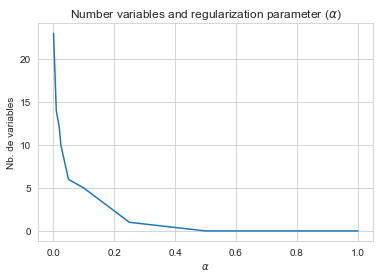

In [26]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

lasso2,data,yindex = make_lasso(df2)

my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])
alpha_for_path, coefs_lasso, _ = lasso_path(np.delete(data, yindex, axis = 1),data[:,yindex],alphas=my_alphas)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)

sns.set_style("whitegrid")
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path).set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')
p
plt.show()

Dans la suite de ce travail, nous allons retenir la valeur $\alpha$ = 0.1, laquelle nous permet de retenir 5 variables explicatives à savoir: **nbapt1pp, nbapt2pp, sbati, sbatact, sapt1pp**

# 5. Régression

In [27]:
# importation des modules nécessaires
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics

## L'échantillonnage

In [28]:
# La variable à expliquer
Y = df3['valeurfonc']
# Les variables explicatives
#X = df3[['nbapt1pp', 'nbapt2pp', 'sbati', 'sbatact', 'sapt1pp']]
X = df3[['sterr', 'nblocmai', 'nblocapt', 'nblocdep', 'nblocact', 'nbapt1pp', 'nbapt2pp', 'nbapt3pp', 'nbapt4pp', 'nbapt5pp', 'nbmai1pp', 'nbmai2pp', 'nbmai3pp', 'nbmai4pp', 'nbmai5pp', 'sbati', 'sbatapt', 'sbatact', 'sapt1pp', 'sapt2pp', 'sapt3pp', 'sapt4pp', 'sapt5pp', 'smai1pp', 'smai2pp', 'smai3pp', 'smai4pp', 'smai5pp', 'nbpprinc', 'nbrcomm']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

## La modélisation

- **Avec Scikit-learn**

In [29]:
ols = LinearRegression().fit(X_train, Y_train)
print(ols.intercept_, ols.coef_)

1.0057178013920958 [-1.18382403e+00 -5.13082338e+10  7.10219680e+03 -7.08725592e+01
 -2.46280408e+02 -7.37816146e+03 -6.88902789e+03 -7.72187050e+03
 -8.21212327e+03 -8.31538805e+03  5.13082369e+10  5.13082270e+10
  5.13082333e+10  5.13082395e+10  5.13082639e+10  9.64469961e+00
 -1.42446104e+12 -9.34857975e+00  1.42446104e+12  1.42446104e+12
  1.42446104e+12  1.42446104e+12  1.42446104e+12  2.78292184e+01
 -4.13617433e+01 -1.69396707e+02 -1.61758354e+02 -2.57331182e+02
  3.47280159e+02 -6.20825107e+00]


- **Avec Statsmodels**

In [30]:
# chargement des modules nécessaires
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = sm.OLS(Y_train, sm.add_constant(X_train)) # NB: on rajoute la constante 1 par mi les regressers car stasmodels ne le fait pas automatiquement
results = model.fit()
print(results.summary())

C:\Users\ethel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:             valeurfonc   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                 1.271e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:04:08   Log-Likelihood:             2.3435e+05
No. Observations:              289994   AIC:                        -4.686e+05
Df Residuals:                  289965   BIC:                        -4.683e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0057      0.000   4498.453      0.0

# La qualité du modèle

In [31]:
# Prédictions
Y_pred = ols.predict(X_test)

# Calcul des métriques de qualité
mse = sklearn.metrics.mean_squared_error(Y_test, Y_pred)
rsq = sklearn.metrics.r2_score(Y_test, Y_pred) 
# The Mean squared error
print('Mean squared error: %.2f'
      % mse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % rsq)

Mean squared error: 0.01
Coefficient of determination: 0.56
